### Imports

In [2]:
import torch 
import numpy as np
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
import os
data= '/kaggle/input/caltech256/256_ObjectCategories'


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

### Transforming and loading images

initial transform (to compute mean/std) <br>
dataset using basic transform

In [5]:
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),                   #default for pretained is 224
    transforms.ToTensor()
])


raw_dataset = datasets.ImageFolder(root=data, transform=basic_transform)

dataloader and std,mean calculation

In [41]:
loader = DataLoader( raw_dataset,batch_size=64, shuffle=False)
mean = 0.
std = 0.
total_images_count = 0
for images, _ in loader:
    images = images.view(images.size(0), images.size(1), -1)  # Flatten H and W: shape becomes (batch_size, channels, H*W)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += images.size(0)

mean /= total_images_count
std /= total_images_count
print("Calculated Mean:", mean)
print("Calculated std:", std)
print("Total number of images used:", total_images_count)


Calculated Mean: tensor([0.5520, 0.5336, 0.5050])
Calculated std: tensor([0.2353, 0.2345, 0.2372])
Total number of images used: 30607


redefine transform using calculated mean and std <br>
reload dataset with normalization

In [6]:
final_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5520, 0.5336, 0.5050],
                         std=[0.2353, 0.2345, 0.2372])
])

final_dataset = datasets.ImageFolder(root=data, transform=final_transform)

In [9]:
final_loader = DataLoader(final_dataset, batch_size=64, shuffle=True)

DataLoader for training

### Train test split

In [7]:
train_ratio = 0.8               #ratio
test_ratio = 0.2

In [8]:
#  total number of images
dataset_size = len(final_dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

In [9]:
# random split
train_dataset, test_dataset = random_split(final_dataset, [train_size, test_size])

In [10]:
# create loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
print(f"Total images: {dataset_size}")
print(f"Train images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")


Total images: 30607
Train images: 24485
Test images: 6122


### CNN Architecture

In [14]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=257):
        super(MyCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32x112x112

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 64x56x56

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 128x28x28

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # Output: 256x4x4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),  # Convert 256x4x4 → 4096
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### initialise model

In [15]:
model = MyCNN().to(device)
print(model)


MyCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

### loss function and adam optimiser

In [16]:
criterion = nn.CrossEntropyLoss()           #multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


### training loop and evaluation using adam optimiser 

In [17]:
# tracking variables
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20
best_val_acc = 0

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


for epoch in range(num_epochs):
    model.train()  
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # track metrics
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # validation Phase 
    model.eval()  
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    # tracking metrics for plotting graph
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Step the LR scheduler
    scheduler.step()

    

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")




Epoch [1/20] Train Loss: 5.1147 | Train Acc: 7.62% | Val Loss: 4.7681 | Val Acc: 10.01%
Epoch [2/20] Train Loss: 4.7080 | Train Acc: 11.07% | Val Loss: 4.4535 | Val Acc: 13.25%
Epoch [3/20] Train Loss: 4.5058 | Train Acc: 12.64% | Val Loss: 4.2567 | Val Acc: 16.37%
Epoch [4/20] Train Loss: 4.3562 | Train Acc: 14.16% | Val Loss: 4.1209 | Val Acc: 18.11%
Epoch [5/20] Train Loss: 4.2443 | Train Acc: 15.59% | Val Loss: 4.0138 | Val Acc: 19.42%
Epoch [6/20] Train Loss: 4.1566 | Train Acc: 16.51% | Val Loss: 3.9122 | Val Acc: 20.27%
Epoch [7/20] Train Loss: 4.0481 | Train Acc: 17.23% | Val Loss: 3.7884 | Val Acc: 22.66%
Epoch [8/20] Train Loss: 3.9744 | Train Acc: 18.27% | Val Loss: 3.7125 | Val Acc: 23.72%
Epoch [9/20] Train Loss: 3.8955 | Train Acc: 19.21% | Val Loss: 3.6156 | Val Acc: 25.04%
Epoch [10/20] Train Loss: 3.8428 | Train Acc: 19.88% | Val Loss: 3.5799 | Val Acc: 25.96%
Epoch [11/20] Train Loss: 3.6590 | Train Acc: 21.98% | Val Loss: 3.4120 | Val Acc: 28.60%
Epoch [12/20] Train 

In [18]:
# saving best model for future use
if val_accuracy > best_val_acc:
    best_val_acc = val_accuracy
    torch.save(model.state_dict(), "best_model.pth")
    print("Saved Best Model")

Saved Best Model


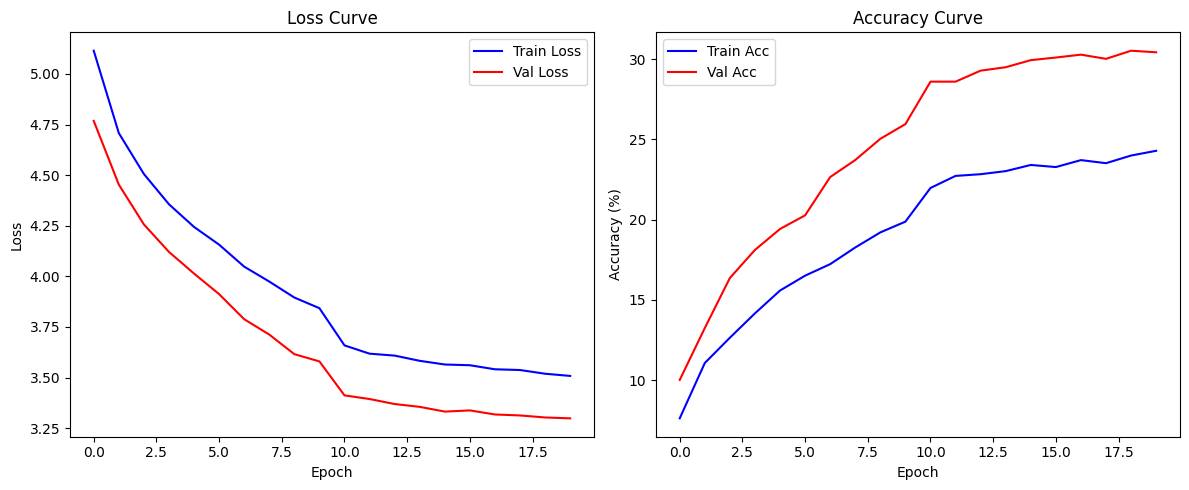

In [20]:
import matplotlib.pyplot as plt

# loading best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# plotting graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Val Loss", color='red')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc", color='blue')
plt.plot(val_accuracies, label="Val Acc", color='red')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

### Using sdg optimiser

In [18]:
model_sgd = MyCNN(num_classes=257).to(device)

criterion_sgd = nn.CrossEntropyLoss()       #loss funtion
 
#SGD optimizer
optimizer_sgd = torch.optim.SGD(
    model_sgd.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4
)

#learning rate scheduler
scheduler_sgd = torch.optim.lr_scheduler.StepLR(optimizer_sgd, step_size=10, gamma=0.1)


tracking variables separate

In [19]:
train_losses_sgd = []
val_losses_sgd = []
train_accuracies_sgd = []
val_accuracies_sgd = []

num_epochs_sgd = 20
best_val_acc_sgd = 0


sdg training loop

In [20]:
for epoch in range(num_epochs_sgd):
    model_sgd.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_sgd(images)
        loss = criterion_sgd(outputs, labels)

        optimizer_sgd.zero_grad()
        loss.backward()
        optimizer_sgd.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model_sgd.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_sgd(images)
            loss = criterion_sgd(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    # Track metrics
    train_losses_sgd.append(avg_train_loss)
    val_losses_sgd.append(avg_val_loss)
    train_accuracies_sgd.append(train_accuracy)
    val_accuracies_sgd.append(val_accuracy)

    scheduler_sgd.step()

    print(f"[SGD Epoch {epoch+1}/{num_epochs_sgd}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")


[SGD Epoch 1/20] Train Loss: 4.9080 | Train Acc: 9.75% | Val Loss: 4.4065 | Val Acc: 14.52%
[SGD Epoch 2/20] Train Loss: 4.3283 | Train Acc: 15.44% | Val Loss: 3.9798 | Val Acc: 19.83%
[SGD Epoch 3/20] Train Loss: 3.9915 | Train Acc: 19.42% | Val Loss: 3.7877 | Val Acc: 22.39%
[SGD Epoch 4/20] Train Loss: 3.7529 | Train Acc: 22.14% | Val Loss: 3.5513 | Val Acc: 26.98%
[SGD Epoch 5/20] Train Loss: 3.5581 | Train Acc: 25.11% | Val Loss: 3.3655 | Val Acc: 29.99%
[SGD Epoch 6/20] Train Loss: 3.3794 | Train Acc: 27.76% | Val Loss: 3.3245 | Val Acc: 30.14%
[SGD Epoch 7/20] Train Loss: 3.2345 | Train Acc: 29.75% | Val Loss: 3.2223 | Val Acc: 31.72%
[SGD Epoch 8/20] Train Loss: 3.0794 | Train Acc: 31.96% | Val Loss: 3.0627 | Val Acc: 35.14%
[SGD Epoch 9/20] Train Loss: 2.9575 | Train Acc: 34.48% | Val Loss: 3.0951 | Val Acc: 33.96%
[SGD Epoch 10/20] Train Loss: 2.8461 | Train Acc: 36.03% | Val Loss: 2.9107 | Val Acc: 37.34%
[SGD Epoch 11/20] Train Loss: 2.5009 | Train Acc: 42.31% | Val Loss: 2

saving sdg

In [21]:
if val_accuracy > best_val_acc_sgd:
    best_val_acc_sgd = val_accuracy
    torch.save(model_sgd.state_dict(), "best_model_sgd.pth")
    print("Saved Best SGD Model")


Saved Best SGD Model


plot

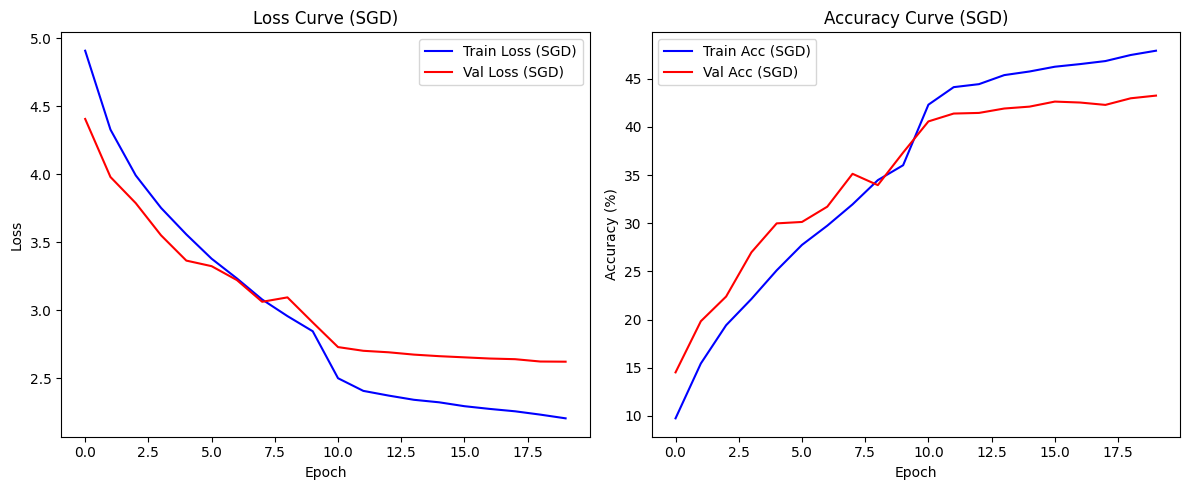

In [23]:
import matplotlib.pyplot as plt
model_sgd.load_state_dict(torch.load("best_model_sgd.pth"))
model_sgd.to(device)
model_sgd.eval()


# Plotting SGD training curves
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label="Train Loss (SGD)", color='blue')
plt.plot(val_losses_sgd, label="Val Loss (SGD)", color='red')
plt.title("Loss Curve (SGD)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_sgd, label="Train Acc (SGD)", color='blue')
plt.plot(val_accuracies_sgd, label="Val Acc (SGD)", color='red')
plt.title("Accuracy Curve (SGD)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


### New CNN

In [12]:
import torch.nn as nn

class MyImprovedCNN(nn.Module):
    def __init__(self, num_classes=257):
        super(MyImprovedCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 x 112 x 112

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 128 x 56 x 56

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 256 x 28 x 28

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))  # 512 x 4 x 4
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


### training using improvedcnn and sdg optimiser

In [37]:
model_imprv = MyImprovedCNN(num_classes=257).to(device)

criterion_imprv = nn.CrossEntropyLoss()       #loss funtion
 
#SGD optimizer
optimizer_imprv = torch.optim.SGD(
    model_imprv.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4
)

#learning rate scheduler
scheduler_imprv = torch.optim.lr_scheduler.StepLR(optimizer_imprv, step_size=10, gamma=0.1)


In [38]:
train_losses_imprv = []
val_losses_imprv = []
train_accuracies_imprv = []
val_accuracies_imprv = []

num_epochs_imprv = 30
best_val_acc_imprv = 0


In [39]:
for epoch in range(num_epochs_imprv):
    model_imprv.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_imprv(images)
        loss = criterion_imprv(outputs, labels)

        optimizer_imprv.zero_grad()
        loss.backward()
        optimizer_imprv.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model_imprv.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_imprv(images)
            loss = criterion_imprv(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    # Track metrics
    train_losses_imprv.append(avg_train_loss)
    val_losses_imprv.append(avg_val_loss)
    train_accuracies_imprv.append(train_accuracy)
    val_accuracies_imprv.append(val_accuracy)

    scheduler_imprv.step()

    print(f"[IMPRV Epoch {epoch+1}/{num_epochs_imprv}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")


[IMPRV Epoch 1/30] Train Loss: 5.0455 | Train Acc: 8.21% | Val Loss: 4.5936 | Val Acc: 11.97%
[IMPRV Epoch 2/30] Train Loss: 4.4609 | Train Acc: 13.28% | Val Loss: 4.2132 | Val Acc: 15.66%
[IMPRV Epoch 3/30] Train Loss: 4.0914 | Train Acc: 17.26% | Val Loss: 3.8917 | Val Acc: 20.52%
[IMPRV Epoch 4/30] Train Loss: 3.7839 | Train Acc: 21.15% | Val Loss: 3.6020 | Val Acc: 25.65%
[IMPRV Epoch 5/30] Train Loss: 3.5183 | Train Acc: 24.90% | Val Loss: 3.4200 | Val Acc: 27.80%
[IMPRV Epoch 6/30] Train Loss: 3.3146 | Train Acc: 27.96% | Val Loss: 3.2676 | Val Acc: 29.58%
[IMPRV Epoch 7/30] Train Loss: 3.1188 | Train Acc: 31.36% | Val Loss: 3.2272 | Val Acc: 31.33%
[IMPRV Epoch 8/30] Train Loss: 2.9751 | Train Acc: 33.51% | Val Loss: 3.2683 | Val Acc: 31.07%
[IMPRV Epoch 9/30] Train Loss: 2.8262 | Train Acc: 36.13% | Val Loss: 2.9593 | Val Acc: 35.58%
[IMPRV Epoch 10/30] Train Loss: 2.7027 | Train Acc: 37.98% | Val Loss: 2.8296 | Val Acc: 37.86%
[IMPRV Epoch 11/30] Train Loss: 2.3053 | Train Acc

In [43]:
if val_accuracy > best_val_acc_imprv:
    best_val_acc_imprv = val_accuracy
    torch.save(model_imprv.state_dict(), "best_model_imprv.pth")
    print("Saved Best Improved Model")


Saved Best Improved Model


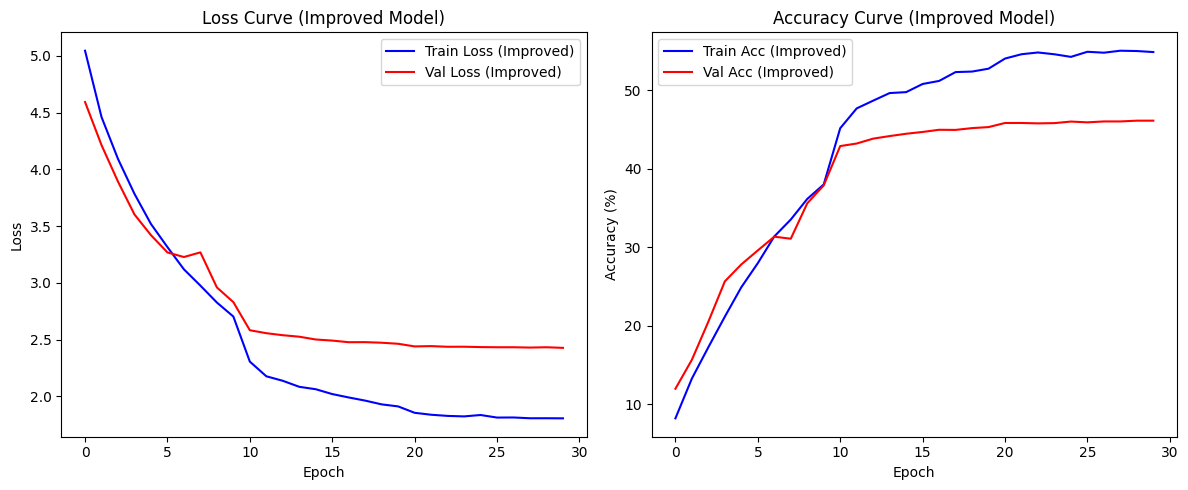

In [44]:
import matplotlib.pyplot as plt

# Load best model
model_imprv.load_state_dict(torch.load("best_model_imprv.pth"))
model_imprv.to(device)
model_imprv.eval()

# Plotting training curves
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses_imprv, label="Train Loss (Improved)", color='blue')
plt.plot(val_losses_imprv, label="Val Loss (Improved)", color='red')
plt.title("Loss Curve (Improved Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_imprv, label="Train Acc (Improved)", color='blue')
plt.plot(val_accuracies_imprv, label="Val Acc (Improved)", color='red')
plt.title("Accuracy Curve (Improved Model)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()


### training using improvedcnn and onecyclelr

In [13]:
import torch.optim as optim

 
# Initialize model
model_onecycle = MyImprovedCNN(num_classes=257).to(device)

# Loss function
criterion_onecycle = nn.CrossEntropyLoss()

# Optimizer (SGD)
optimizer_onecycle = optim.SGD(
    model_onecycle.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4
)

# Scheduler: OneCycleLR
num_epochs_onecycle = 20
scheduler_onecycle = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_onecycle,
    max_lr=0.1,  # Peak LR
    steps_per_epoch=len(train_loader),
    epochs=num_epochs_onecycle,
    pct_start=0.3,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1e4
)

# Tracking lists
train_losses_onecycle = []
val_losses_onecycle = []
train_accuracies_onecycle = []
val_accuracies_onecycle = []

best_val_acc_onecycle = 0

# Training loop
for epoch in range(num_epochs_onecycle):
    model_onecycle.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_onecycle(images)
        loss = criterion_onecycle(outputs, labels)

        optimizer_onecycle.zero_grad()
        loss.backward()
        optimizer_onecycle.step()
        scheduler_onecycle.step()  # Important: called every batch

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model_onecycle.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model_onecycle(images)
            loss = criterion_onecycle(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    # Track metrics
    train_losses_onecycle.append(avg_train_loss)
    val_losses_onecycle.append(avg_val_loss)
    train_accuracies_onecycle.append(train_accuracy)
    val_accuracies_onecycle.append(val_accuracy)

    # Save best model
    if val_accuracy > best_val_acc_onecycle:
        best_val_acc_onecycle = val_accuracy
        torch.save(model_onecycle.state_dict(), "best_model_onecycle.pth")
        print("Saved Best OneCycle Model")

    print(f"[OneCycle Epoch {epoch+1}/{num_epochs_onecycle}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")


Saved Best OneCycle Model
[OneCycle Epoch 1/20] Train Loss: 5.0997 | Train Acc: 7.68% | Val Loss: 4.8324 | Val Acc: 9.82%
Saved Best OneCycle Model
[OneCycle Epoch 2/20] Train Loss: 4.6796 | Train Acc: 11.10% | Val Loss: 4.5234 | Val Acc: 12.81%
Saved Best OneCycle Model
[OneCycle Epoch 3/20] Train Loss: 4.6288 | Train Acc: 11.60% | Val Loss: 4.3355 | Val Acc: 15.08%
Saved Best OneCycle Model
[OneCycle Epoch 4/20] Train Loss: 4.2895 | Train Acc: 15.01% | Val Loss: 3.9777 | Val Acc: 18.77%
Saved Best OneCycle Model
[OneCycle Epoch 5/20] Train Loss: 3.9603 | Train Acc: 18.80% | Val Loss: 3.9044 | Val Acc: 19.36%
Saved Best OneCycle Model
[OneCycle Epoch 6/20] Train Loss: 3.7212 | Train Acc: 22.11% | Val Loss: 3.5500 | Val Acc: 24.98%
Saved Best OneCycle Model
[OneCycle Epoch 7/20] Train Loss: 3.5104 | Train Acc: 25.09% | Val Loss: 3.4177 | Val Acc: 27.05%
Saved Best OneCycle Model
[OneCycle Epoch 8/20] Train Loss: 3.3045 | Train Acc: 27.97% | Val Loss: 3.1935 | Val Acc: 31.87%
Saved Best

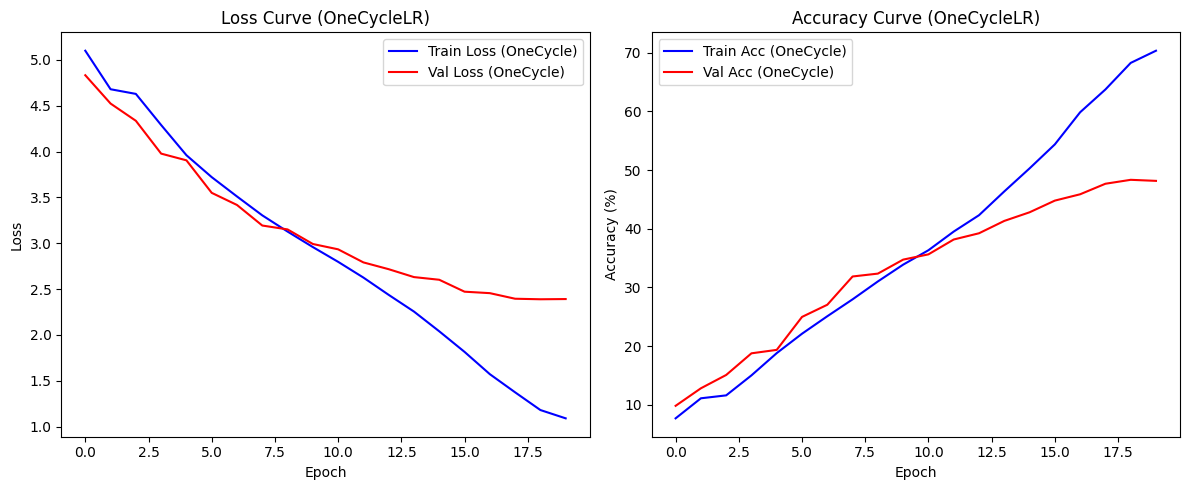

In [14]:
import matplotlib.pyplot as plt

# Load the best saved OneCycleLR model
model_onecycle.load_state_dict(torch.load("best_model_onecycle.pth"))
model_onecycle.to(device)
model_onecycle.eval()

# Plotting OneCycleLR training curves
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses_onecycle, label="Train Loss (OneCycle)", color='blue')
plt.plot(val_losses_onecycle, label="Val Loss (OneCycle)", color='red')
plt.title("Loss Curve (OneCycleLR)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_onecycle, label="Train Acc (OneCycle)", color='blue')
plt.plot(val_accuracies_onecycle, label="Val Acc (OneCycle)", color='red')
plt.title("Accuracy Curve (OneCycleLR)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()
